<a href="https://colab.research.google.com/github/Maziger/master-generative-ai-with-llm/blob/main/Take_home_exam_assignments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1
Follow the classification example in Chapter 6 in Hands-On Generative AI with Transformers and Diffusion Models and extend it in the following ways:

## 1. Perform an error analysis based on the fine-tuned DestilBert model on the AG News dataset.

### Fine-tuning DestilBert

* Printing and logging settings
  * Wraps text and keeps notebook cleaner

In [4]:
import datasets
import numpy as np
import torch
import transformers

np.set_printoptions(edgeitems=10, linewidth=70)
torch.set_printoptions(edgeitems=10, linewidth=70)
transformers.logging.set_verbosity_warning()
datasets.logging.set_verbosity_error()

* Load in the AG News dataset

In [1]:
from datasets import load_dataset

raw_datasets = load_dataset("ag_news")
raw_datasets

README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})

In [5]:
raw_train_dataset = raw_datasets["train"]
raw_train_dataset[0]

{'text': "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.",
 'label': 2}

In [6]:
print(raw_train_dataset.features)

{'text': Value('string'), 'label': ClassLabel(names=['World', 'Sports', 'Business', 'Sci/Tech'])}


* Tokenize the dataset

In [7]:
from transformers import AutoTokenizer

checkpoint = "distilbert/distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)


def tokenize_function(batch):
    return tokenizer(
        batch["text"], truncation=True, padding=True, return_tensors="pt"
    )


tokenize_function(raw_train_dataset[:2])

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

{'input_ids': tensor([[  101,  2813,  2358,  1012,  6468, 15020,  2067,  2046,
          1996,  2304,  1006, 26665,  1007, 26665,  1011,  2460,
          1011, 19041,  1010,  2813,  2395,  1005,  1055,  1040,
         11101,  2989,  1032,  2316,  1997, 11087,  1011, 22330,
          8713,  2015,  1010,  2024,  3773,  2665,  2153,  1012,
           102,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0],
        [  101, 18431,  2571,  3504,  2646,  3293, 13395,  1006,
         26665,  1007, 26665,  1011,  2797,  5211,  3813, 18431,
          2571,  2177,  1010,  1032,  2029,  2038,  1037,  5891,
          2005,  2437,  2092,  1011, 22313,  1998,  5681,  1032,
          6801,  3248,  1999,  1996,  3639,  3068,  1010,  2038,
          5168,  2872,  1032,  2049, 29475,  2006,  2178,  2112,
          1997,  1996,  3006,  1012,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 

* Adding input_ids and attention_mask

In [9]:
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
tokenized_datasets

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 7600
    })
})

* Define evaluation metrics

In [13]:
%pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.7 MB/s eta 0:00:00


In [14]:
import evaluate

accuracy = evaluate.load("accuracy")
print(accuracy.description)
print(accuracy.compute(references=[0, 1, 0, 1], predictions=[1, 0, 0, 1]))


Accuracy is the proportion of correct predictions among the total number of cases processed. It can be computed with:
Accuracy = (TP + TN) / (TP + TN + FP + FN)
 Where:
TP: True positive
TN: True negative
FP: False positive
FN: False negative

{'accuracy': 0.5}


In [15]:
f1_score = evaluate.load("f1")


def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    # Compute accuracy and F1 Score
    acc_result = accuracy.compute(references=labels, predictions=preds)
    acc = acc_result["accuracy"]

    f1_result = f1_score.compute(
        references=labels, predictions=preds, average="weighted"
    )
    f1 = f1_result["f1"]

    return {"accuracy": acc, "f1": f1}

* Prepare to push model to huggingface

In [16]:
from huggingface_hub import notebook_login

notebook_login()

* Train model

In [21]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [26]:
from transformers import TrainingArguments

batch_size = 64  # You can change this if you have a big or small
num_labels = 4
model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint, num_labels=num_labels
).to(device)
training_args = TrainingArguments(
    "assignment1_DestilBert",
    push_to_hub=True,
    num_train_epochs=2,
    eval_strategy="epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    report_to="none"
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
from transformers import Trainer

# Shuffle the dataset and pick 10,000 examples for training
shuffled_dataset = tokenized_datasets["train"].shuffle(seed=42)
small_split = shuffled_dataset.select(range(10000))

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=small_split,
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
)
trainer.train()

/tmp/ipython-input-2244742712.py:8: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.276856,0.908684,0.908288
2,No log,0.247492,0.916579,0.916547


TrainOutput(global_step=314, training_loss=0.30165187568421575, metrics={'train_runtime': 700.4984, 'train_samples_per_second': 28.551, 'train_steps_per_second': 0.448, 'total_flos': 1910301836112768.0, 'train_loss': 0.30165187568421575, 'epoch': 2.0})

Model showcases an F1 score on the validation set of approx. 91%

* Test if the model works on a sample text

In [36]:
from transformers import pipeline

pipe = pipeline(
    "text-classification",
    model="genaibook/classifier-chapter4",
    device="cuda",
)
pipe(
    """The soccer match between Spain and
Portugal ended in a terrible result for Portugal."""
)

Device set to use cuda


[{'label': 'Sports', 'score': 0.8631355166435242}]

In [53]:
# Get prediction for all samples
model_preds = pipe(list(tokenized_datasets["test"]["text"]))

# Get the dataset labels
references = tokenized_datasets["test"]["label"]

# Get the list of label names
label_names = raw_train_dataset.features["label"].names

# Print results of the first 3 samples
samples = 3
texts = tokenized_datasets["test"]["text"][:samples]
for pred, ref, text in zip(model_preds[:samples], references[:samples], texts):
    print(f"Predicted {pred['label']}; Actual {label_names[ref]};")
    print(text)

Predicted Business; Actual Business;
Fears for T N pension after talks Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul.
Predicted Sci/Tech; Actual Sci/Tech;
The Race is On: Second Private Team Sets Launch Date for Human Spaceflight (SPACE.com) SPACE.com - TORONTO, Canada -- A second\team of rocketeers competing for the  #36;10 million Ansari X Prize, a contest for\privately funded suborbital space flight, has officially announced the first\launch date for its manned rocket.
Predicted Sci/Tech; Actual Sci/Tech;
Ky. Company Wins Grant to Study Peptides (AP) AP - A company founded by a chemistry researcher at the University of Louisville won a grant to develop a method of producing better peptides, which are short chains of amino acids, the building blocks of proteins.


* Plot confusion matrix

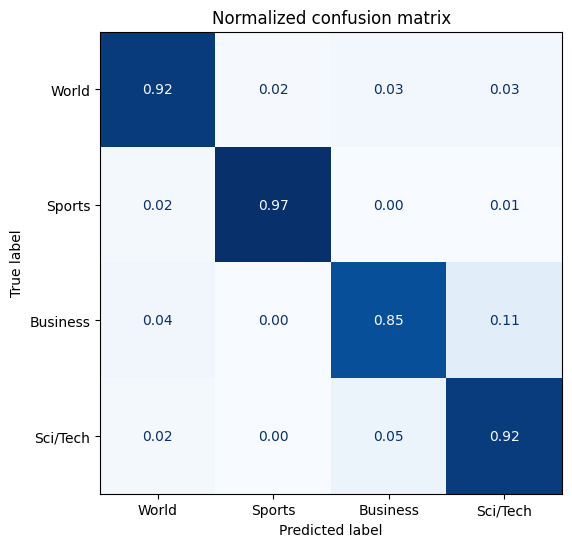

In [54]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Convert predicted labels to ids
label_to_id = {name: i for i, name in enumerate(label_names)}
pred_labels = [label_to_id[pred["label"]] for pred in model_preds]

# Compute confusion matrix
confusion_matrix = evaluate.load("confusion_matrix")
cm = confusion_matrix.compute(
    references=references, predictions=pred_labels, normalize="true"
)["confusion_matrix"]

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
plt.title("Normalized confusion matrix")
plt.show()

Noticeable that the Business category is sometimes confused with Sci/Tech (0.11).

In [55]:
trainer.push_to_hub(commit_message="Completed training")

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...assifier-chapter4/training_args.bin: 100%|##########| 5.78kB / 5.78kB            

  ...ents.1757867390.85fc46045720.1783.0: 100%|##########| 5.06kB / 5.06kB            

  ...ents.1757867449.85fc46045720.1783.1: 100%|##########| 5.06kB / 5.06kB            

  ...assifier-chapter4/model.safetensors:  13%|#2        | 33.5MB /  268MB            

CommitInfo(commit_url='https://huggingface.co/Maziger1/classifier-chapter4/commit/0fa79d9658ca971bb7f2a39de72fc1332e4db2c1', commit_message='Completed training', commit_description='', oid='0fa79d9658ca971bb7f2a39de72fc1332e4db2c1', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Maziger1/classifier-chapter4', endpoint='https://huggingface.co', repo_type='model', repo_id='Maziger1/classifier-chapter4'), pr_revision=None, pr_num=None)

### Error analysis

In [ ]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device),
                             reduction="none")

    # Place outputs on CPU for compatibility with other dataset columns
    return {"loss": loss.cpu().numpy(),
            "predicted_label": pred_label.cpu().numpy()}

## 2. Fine-tune a ModernBert model (answerdotai/ModernBERT-base) in a similar fashion as DestilBert was fine-tuned in the chapter.

## 3. Compare the test set performance of the two fine-tuned models.

## 4. Perform an error analysis on the AG News based on the fine-tuned ModernBert and compare it to DestilBert.

# Assignment 2